# Options Pricing via Finite Differences

## Two extreme cases for illustrative purposes:

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import bs as bs

In [16]:
def tridiagSolver(l, d, u, f):
    
    ''' 
    Tridiagonal solver 
    '''
    
    n = len(f)
    v = np.zeros(n)
    y = np.zeros(n)
    w = d[0]
    y[0] = 1.0 * f[0] / w
    
    for i in range(1, n):
        v[i-1] = 1. * u[i-1] / w
        w = d[i] - l[i] * v[i-1]
        y[i] = 1. * (f[i] - l[i] * y[i-1]) / w
    
    for j in range(n-2, -1, -1):
        y[j] = y[j] - v[j] * y[j+1]
    
    return y

In [25]:

type_option = 'american'
#type_option = 'european'

boundary = 'neumann'
#boundary = 'dirichlet'

#scenario
scenario = '1'

if scenario == '1':
    r = 0.0541
    q = 0.012
elif scenario == '2':
    r = 0.01
    q = 0.1


S = 1000
K = 1300

sig = 0.3
T = 1

# 0,1,2,...,N,N+1




sMin = 100
sMax = 4000

N = 2000
M = 365

dS = (sMax - sMin) / N
dT = T / M

s = np.zeros(N-1)
tau = np.zeros(M)

l = np.zeros(N-1)
u = np.zeros(N-1)
d = np.zeros(N-1)

vCall = np.zeros(N-1)
vPut = np.zeros(N-1)

alpha = 0.5 * (sig ** 2) * dT / (dS ** 2)
beta = (r - q) * dT / (2.0 * dS)

# tridiagonal matrix
s = sMin + np.arange(1, N) * dS
l = -alpha * (s ** 2) + beta * s
l[0] = 0
d = 1 + r * dT + 2 * alpha * (s ** 2)
u = -alpha * (s ** 2) - beta * s
u[-1] = 0

if boundary == 'neumann':
    l[-1] = 2 * beta * s[-1]
    d[0] = 1 + r * dT + 2 * beta * s[0]
    d[-1] = 1 + r * dT - 2 * beta * s[-1]
    u[0] = -2 * beta * s[0]
    
# exercise boundaries
if type_option == 'american':
    SxCall = np.zeros(M)
    SxPut = np.zeros(M)

tau = dT * np.arange(1, M+1)

In [26]:
print('type_option = ' + str(type_option))
print ('boundary_conditions = ' + str(boundary))
# way slower than Matlab!!
vCall = np.maximum(s - K, 0)
vPut = np.maximum(K - s, 0)
for j in range(M):
    # print progress
    if (j+1) % 50 == 0:
        print('iter = ' + str(j+1))
    ######################
    # calls
    if boundary == 'dirichlet':
        if type_option == 'american':
            tmp_pay = sMax - K
        else:
            tmp_pay = sMax*np.exp(-r*dT*j) - K*np.exp(-q*dT*j)
        vCall[-1] -= tmp_pay * (-alpha * (sMax ** 2) - beta * sMax)
    vCall = tridiagSolver(l, d, u, vCall)
    if type_option == 'american':
        flagC = 0
        for i in range(N-2, -1, -1):
            # exercise boundary
            if (flagC == 0) and (vCall[i] > np.maximum(s[i] - K, 0)):
                SxCall[j] = s[i]
                flagC = 1
            # premium
            if vCall[i] <= np.maximum(s[i] - K, 0):
                vCall[i] = np.maximum(s[i] - K, 0)
    # puts
    if boundary == 'dirichlet':
        if type_option == 'american':
            tmp_pay = K - sMin
        else:
            tmp_pay = K*np.exp(-q*dT*j) - sMin*np.exp(-r*dT*j)
        vPut[0] -= tmp_pay * (-alpha * (sMin ** 2) + beta * sMin)
    vPut = tridiagSolver(l, d, u, vPut)
    if type_option == 'american':
        flagP = 0
        for i in range(N-1):
            # exercise boundary
            if (flagP == 0) and (vPut[i] > np.maximum(K - s[i], 0)):
                SxPut[j] = s[i]
                flagP = 1
            # premium
            if vPut[i] <= np.maximum(K - s[i], 0):
                vPut[i] = np.maximum(K - s[i], 0)
print('Done')

type_option = american
boundary_conditions = neumann
iter = 50
iter = 100
iter = 150
iter = 200
iter = 250
iter = 300
iter = 350
Done


In [27]:
# one spot price
call_fd = np.interp(S, s, vCall)
put_fd = np.interp(S, s, vPut)

callEuropean = bs.BS_price('call', S, K, r, q, sig, T)
putEuropean = bs.BS_price('put', S, K, r, q, sig, T)

print('European call (BMS): ' + str(callEuropean))
if type_option == 'american':
    print('American call (FD): ' + str(call_fd))
else:
    print('European call (FD): ' + str(call_fd))
    
print('European put (BMS): ' + str(putEuropean))
if type_option == 'american':
    print('American put (FD): ' + str(put_fd))
else:
    print('European put (FD): ' + str(put_fd))
    
# all spot prices
eCall = bs.BS_price('call', s, K, r, q, sig, T)
ePut = bs.BS_price('put', s, K, r, q, sig, T)

European call (BMS): 44.31692885015838
American call (FD): 44.31236517785231
European put (BMS): 287.783794424824
American put (FD): 310.62443926441483


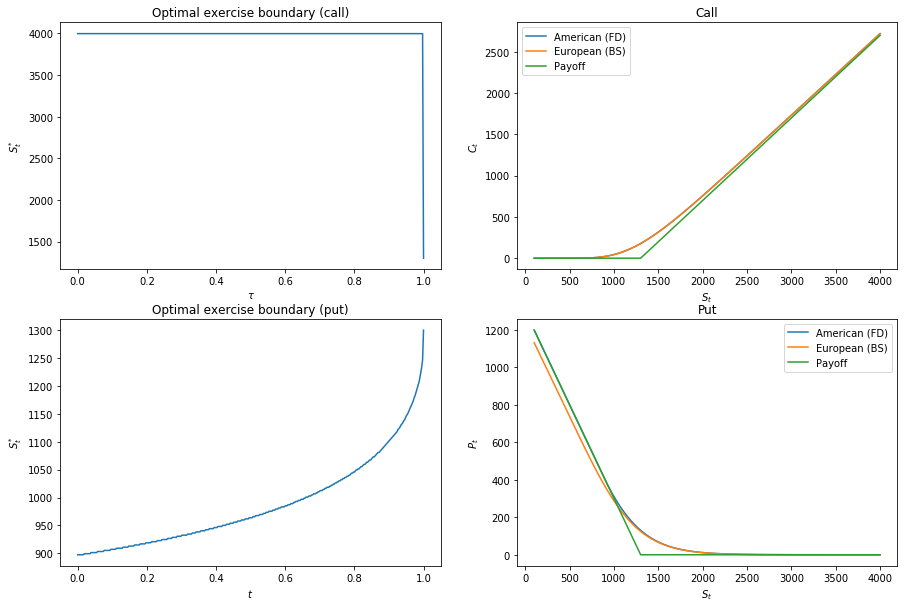

In [28]:
if type_option == 'american':
    plt.figure(figsize=(15,10))

    plt.subplot(2,2,1)
    tmp = np.sort(np.append(K, SxCall))[::-1]
    plt.plot(np.append(0,tau), tmp)
    plt.xlabel('$\\tau$')
    plt.ylabel('$S^{*}_t$')
    plt.title('Optimal exercise boundary (call)')

    plt.subplot(2,2,2)
    plt.plot(s, vCall)
    plt.plot(s, eCall)
    plt.plot(s, np.maximum(s-K, 0))
    plt.xlabel('$S_t$')
    plt.ylabel('$C_t$')
    plt.title('Call')
    plt.legend(['American (FD)', 'European (BS)', 'Payoff'])

    # calendar time as opposed to time-to-maturity
    plt.subplot(2,2,3)
    tmp = np.sort(np.append(K, SxPut))
    plt.plot(np.append(0,tau), tmp)
    plt.xlabel('$t$')
    plt.ylabel('$S^{*}_t$')
    plt.title('Optimal exercise boundary (put)')

    plt.subplot(2,2,4)
    plt.plot(s, vPut)
    plt.plot(s, ePut)
    plt.plot(s, np.maximum(K-s, 0))
    plt.xlabel('$S_t$')
    plt.ylabel('$P_t$')
    plt.title('Put')
    plt.legend(['American (FD)', 'European (BS)', 'Payoff'])
else:
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,2,1)
    plt.plot(s, vCall)
    plt.plot(s, eCall)
    plt.plot(s, np.maximum(s-K, 0))
    plt.xlabel('$S_t$')
    plt.ylabel('$C_t$')
    plt.title('Call')
    plt.legend(['European (FD)', 'European (BS)', 'Payoff'])
    
    plt.subplot(1,2,2)
    plt.plot(s, vPut)
    plt.plot(s, ePut)
    plt.plot(s, np.maximum(K-s, 0))
    plt.xlabel('$S_t$')
    plt.ylabel('$P_t$')
    plt.title('Put')
    plt.legend(['European (FD)', 'European (BS)', 'Payoff'])


plt.show()
#plt.savefig('options_via_fd.pdf')